# Code to group the TC GPI as per the MJO phases for the Monsoon Onset period 

# NCSU Tropical Dynamics 
# April 2023
# A. Aiyyer and S. Dhavale

In [3]:
import re
from datetime import date, datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import geocat.viz as gv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter

In [4]:
def plot_GPI(GPI,latS,latN,lonW,lonE,minC,maxC,intC,colormap):
 
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
    from geocat.viz import util as gvutil
    from shapely.geometry.polygon import LinearRing

    levC = int((maxC-minC)/intC) + 1

# Generate figure (set its size (width, height) in inches)
    fig = plt.figure(figsize=(18,8))

# Generate axes, using Cartopy, drawing coastlines, and adding features
    projection = ccrs.PlateCarree()

    ax = plt.axes(projection=projection)
    ax.coastlines(linewidths=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Import an NCL colormap
    #newcmp = gvcmaps.BlAqGrYeOrRe
    #newcmp = 'YlOrBr'  #'YlGn' #'coolwarm'  #gvcmaps.ncl_default
    #newcmp = gvcmaps.BlAqGrYeOrRe
    #cmap =  'PuOr_r' # reversed colors using _r

    
    contourLevels = np.arange(minC, maxC, intC)
    vmaxMap = GPI.plot.contourf(ax=ax,
                          transform=projection,
                          vmin=minC,
                          vmax=maxC,
                          levels=contourLevels,
                          cmap=colormap,
                          add_colorbar=False)


    gvutil.set_axes_limits_and_ticks(ax,
                                     xlim=(lonW, lonE),
                                     ylim=(latS, latN),
                                     xticks=np.linspace(lonW,lonE , 6),
                                     yticks=np.linspace(latS, latN,3))
    
    
     # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax)

  
    # Use geocat.viz.util convenience function to add titles
    gv.set_titles_and_labels(ax,
                         lefttitle='GPI',
                         righttitle=' ',
                         lefttitlefontsize=12,
                         righttitlefontsize=12)
  
    
    # Use geocat.viz.util convenience function to make latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)
    # Remove degree symbol from tick labels
    
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    
    
    # Do not label (title) the lat and lon axis
    ax.set(xlabel=None)
    ax.set(ylabel=None)

    # Add colorbar
    cbar = plt.colorbar(vmaxMap, orientation='horizontal',fraction=0.1,
                        ticks=np.arange(minC, maxC, intC),
                        shrink=0.75,pad=0.15,
                        extendrect=True,extendfrac='auto')
    
    return ax
#cbar.ax.set_yticklabels([str(i) for i in np.arange(minC, maxC, intC)])
#cbar.ax.set_yticklabels(str(conto

In [5]:
# first set the years and months for the processing
# we shall allow for seclecting specific range of dates within each year


year_start  = 1982
month_start = 5
day_start   = 5

year_end  = 2021
month_end = 6
day_end   = 20

date_series = [pd.date_range(date(i,month_start,day_start),date(i,month_end,day_end), freq ='D') for i in range(year_start,year_end+1)]
# date_series is a list of lists. Lets unpack it now
dates_list = [element for sublist in date_series for element in sublist]

In [6]:
len(dates_list)
#date_series

1880

In [7]:
mov_file = 'mov_formation_ibtracs_imd_final.ascii'
mov = pd.read_csv (mov_file,delim_whitespace=True)
mov['date'] = pd.to_datetime(mov['date'], format='%Y%m%d', errors='coerce')

In [8]:
rmm_file = 'rmm.74toRealtime.txt'
rmm = pd.read_csv (rmm_file,skiprows=2,header=None,delim_whitespace=True)
rmm.columns = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase_original', 'amplitude', 'junk']

# combine the year month and day to get a date:
rmm['date'] = pd.to_datetime(rmm[['year', 'month', 'day']])
rmm.drop(columns=['year', 'month', 'day','junk'], inplace=True)

# Now replace the phase corresponding to amplitudes < 1 with phase=0
# Now we have phase=0 for weak MJO events

rmm['phase'] = rmm.phase_original.where(rmm.amplitude>1, 0)

# a quick look at the phases that got replaced
#print(rmm[rmm.phase==0].to_string())
rmm.head()


# now subset the rmm for only the premonsoon dates
rmm_subset = rmm[rmm.date.isin(dates_list)].reset_index()

In [9]:
# create a new pandas dataframe that will hold the RMM info for
# the MOV dates: D0,P1,M1  --> day0, day+1, day-1

mov_phase = pd.DataFrame()
mov_phase['phase_D0'] = rmm[rmm['date'].isin(mov.date)].reset_index().phase
mov_phase['phase_P1'] = rmm[rmm['date'].isin(mov.date +  pd.Timedelta(1, "d"))].reset_index().phase
mov_phase['phase_M1'] = rmm[rmm['date'].isin(mov.date +  pd.Timedelta(-1, "d"))].reset_index().phase
mov_phase[ ['date', 'lon', 'lat'] ] = mov[ ['date','lon','lat'] ]

In [10]:
rmm_subset

,index,RMM1,RMM2,phase_original,amplitude,date,phase
0,2895,0.339553,0.730542,6,0.805597,1982-05-05,0
1,2896,0.044436,0.648857,6,0.650377,1982-05-06,0
2,2897,-0.312830,0.530547,7,0.615906,1982-05-07,0
3,2898,-0.565060,0.531997,8,0.776085,1982-05-08,0
4,2899,-0.646130,0.628160,8,0.901148,1982-05-09,0
...,...,...,...,...,...,...,...
1875,17182,-0.413090,-1.400404,2,1.460060,2021-06-16,2
1876,17183,-0.455107,-1.107249,2,1.197131,2021-06-17,2
1877,17184,-0.374322,-1.001451,2,1.069122,2021-06-18,2
1878,17185,-0.474960,-0.627858,2,0.787269,2021-06-19,0


In [11]:
# kotal gpp
#dataDir = '/glade/scratch/aiyyer/data/kgpp_gpi/'
#fileNames =[dataDir + 'kgpp' + fn.strftime('%Y%m%d')+ '.nc' for fn in dates_list]


# EN GPI
#dataDir = '/glade/scratch/aiyyer/data/era5_EN_GPI/'
dataDir = '/glade/work/aiyyer/era5_EN_GPI/'
fileNames =[dataDir + 'EN' + fn.strftime('%Y%m%d')+ '.nc' for fn in dates_list]


GP_index = 'GPI'    # 'GPI' KGPP
#GP_index = 'KGPP'    # 'GPI' KGPP

In [12]:
# since the GPI files do not have a time dimension, we will need to expand the 
# dimensions for the xr.open.mfdataset to correctly join the daily files

# define a preprocess function where we extract the time info from the filename

def preprocess(ds):
    # include a dummy path
    var = next(var for var in ds)
    path=ds[var].encoding['source']
    match_str = re.search(r'\d{4}\d{2}\d{2}', str(path))
    time = pd.to_datetime(datetime.strptime(match_str.group(), '%Y%m%d'))
    return ds.assign_coords(time = [time])

# now read all the files in parallel
ds = xr.open_mfdataset(fileNames, preprocess=preprocess,  combine='nested' , concat_dim='time', parallel=True)

In [13]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 181, time: 1880)
Coordinates:
  * latitude   (latitude) float64 30.0 29.75 29.5 29.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float64 40.0 40.25 40.5 40.75 ... 84.5 84.75 85.0
  * time       (time) datetime64[ns] 1982-05-05 1982-05-06 ... 2021-06-20
Data variables:
    GPI        (time, latitude, longitude) float32 dask.array<chunksize=(1, 121, 181), meta=np.ndarray>

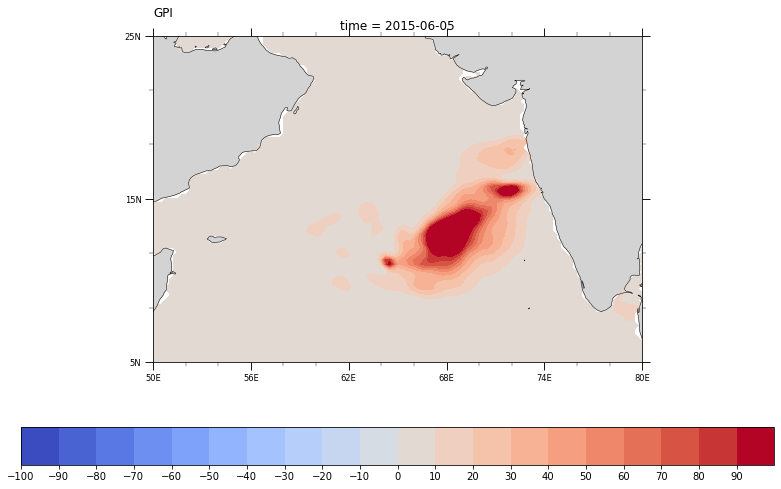

In [14]:
# plot anom for one day
minC = -20
maxC =  20
intC =  2.

minC = -100
maxC =  100
intC =  10.



minlon =  50.
maxlon =  80.
minlat =   5.
maxlat =   25.
colormap='coolwarm'
ax=plot_GPI(ds.GPI.sel(time='2015-06-05'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
#ax=plot_GPI(ds.KGPP.sel(time='1983-06-05'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)


plt.show()

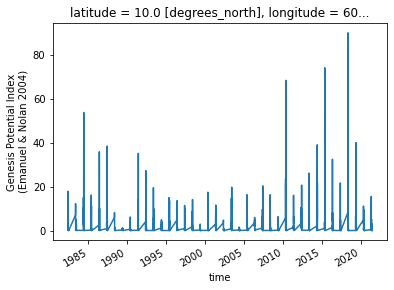

In [15]:
# read the GPI index and replace nan with zero for kotal gpp
GP = ds[GP_index].fillna(0.)


#GP = ds[GP_index]

# a quick peek
GP.sel(longitude=60.,latitude=10.).plot()

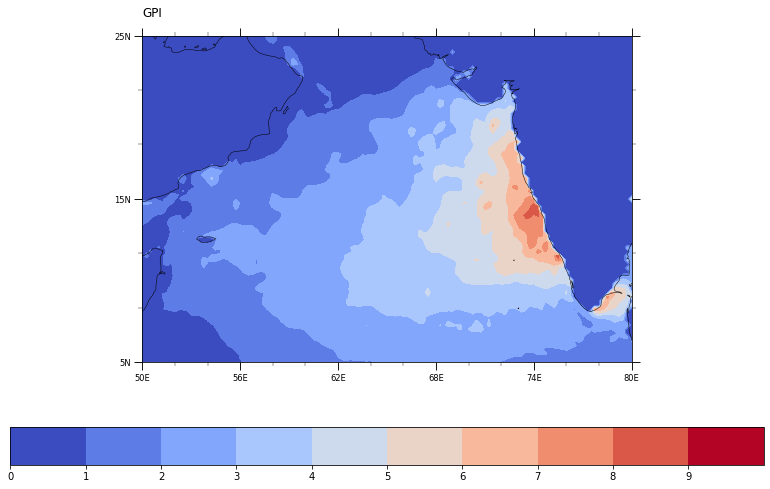

In [16]:
minC = 0
maxC = 10
intC = 1.

minlon =  50.
maxlon =  80.
minlat =   5.
maxlat =   25.

colormap='coolwarm'

ax=plot_GPI(GP.mean(dim='time'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)

plt.show()

In [17]:
print (GP.mean(dim='time').min().values, GP.mean(dim='time').max().values)
print (GP.median(dim='time').min().values, GP.median(dim='time').max().values)
print (GP.min().values, GP.max().values)

0.0 10.001375
0.0 6.196171
-1.0135971e-07 3837.2039


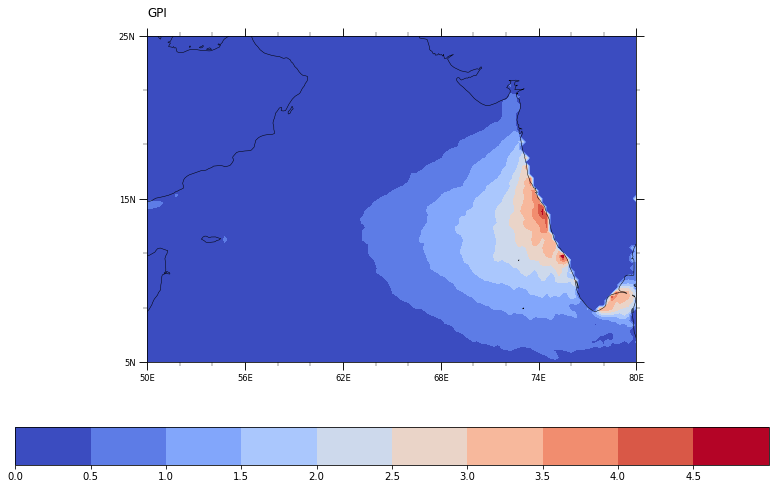

In [18]:
minC = 0
maxC = 5
intC = .5

minlon =  50.
maxlon =  80.
minlat =   5.
maxlat =   25.

colormap='coolwarm'

ax=plot_GPI(GP.median(dim='time'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)

plt.show()

In [19]:
# group the data by day and calculate the long-term mean (LTM) climatology
gb = GP.groupby(ds.time.dt.dayofyear)

#print( gb.count(dim='time').sel(longitude=60.,latitude=10.).values )
#ic = 0
#for d1,d2 in zip(ds.time.dt.dayofyear.values, ds.time.values):
#    if ( d1 == 132):
#        ic = ic + 1
#        print (ic, d1,d2)

In [20]:
#
clim = gb.mean(dim='time')

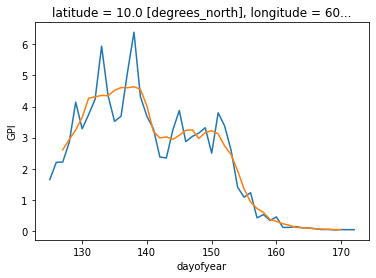

In [21]:
window_days = 2
climS = clim.rolling(dayofyear=window_days*2+1, center=True).mean()

clim.sel(longitude=60.,latitude=10.).plot()
climS.sel(longitude=60.,latitude=10.).plot()

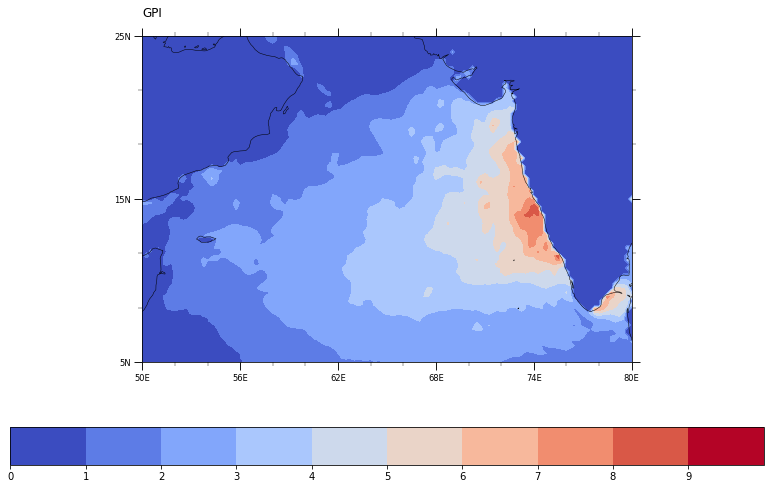

In [22]:
# quick peek at the mean over all days
minC = 0
maxC = 10
intC = 1.
ax=plot_GPI(clim.mean(dim='dayofyear'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)

In [23]:
anom  =  gb-climS


/glade/u/apps/opt/conda/envs/npl/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


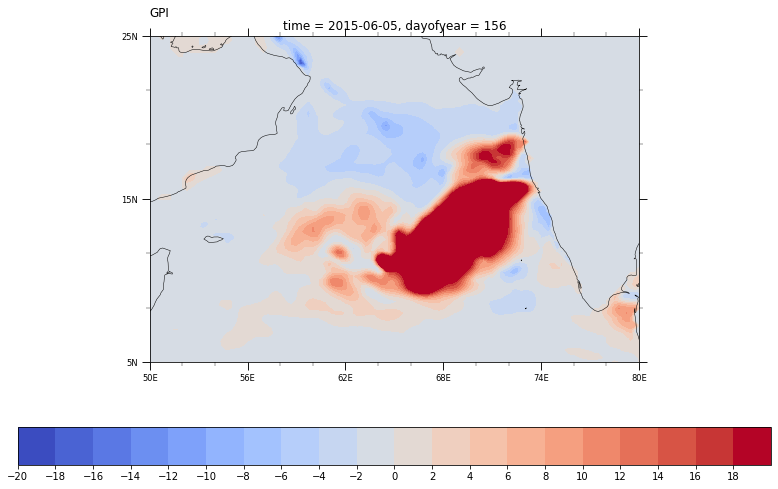

In [24]:
# plot anom for one day
minC = -20
maxC =  20
intC =  2.
colormap='coolwarm'
ax=plot_GPI(anom.sel(time='2015-06-05'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
plt.show()

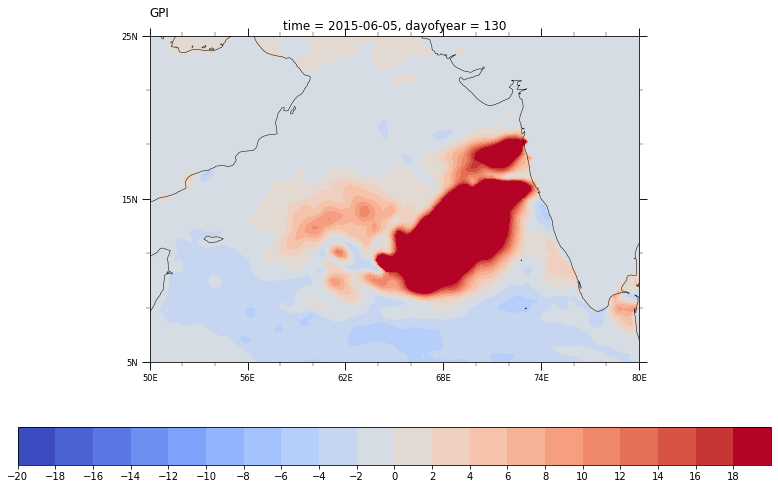

In [25]:
# confirm anom is being calcualated correctly
# fig below should be identical to one above
data = GP.sel(time='2015-06-05') - clim.sel(dayofyear=130)
ax=plot_GPI(data,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
plt.show()

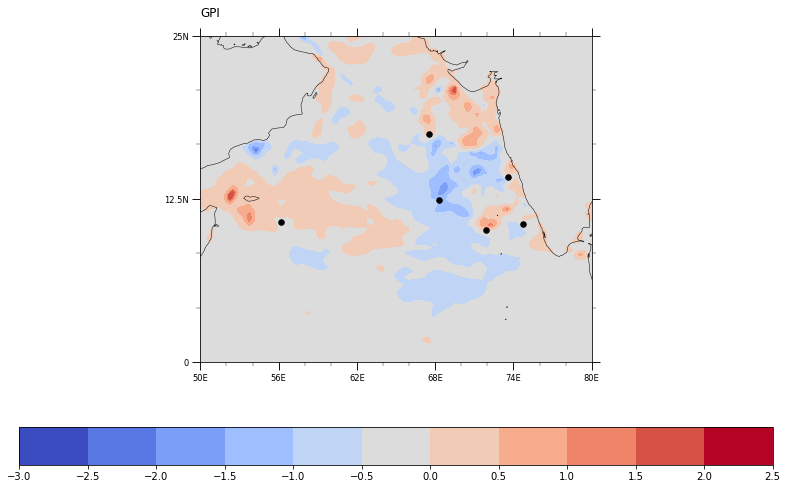

In [26]:
minlon =  50.
maxlon =  80.
minlat =   0.
maxlat =   25.
minC = -3
maxC =  3
intC =  .5

zero_phases = [0]
dates_zero = rmm_subset[rmm_subset.phase.isin(zero_phases)].date.values
GP_zero  = anom.sel(time=dates_zero).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_zero,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

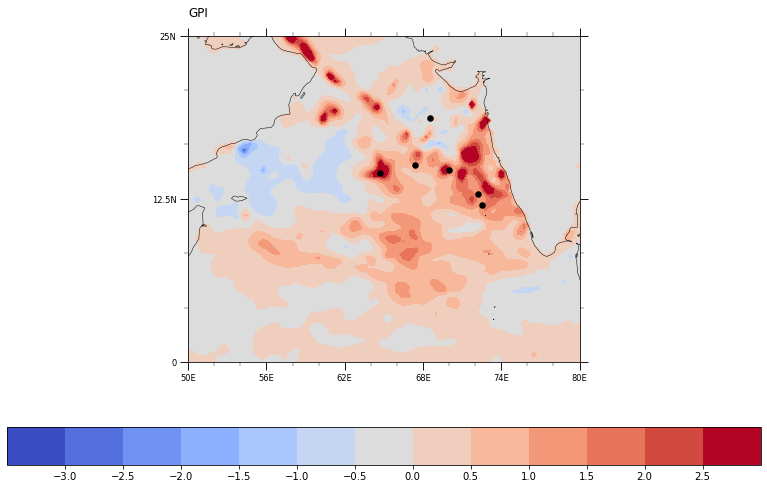

In [27]:
minlon =  50.
maxlon =  80.
minlat =   0.
maxlat =   25.
minC = -3
maxC =  3
intC =  .5

transition_phases = [1,5]
dates_transition = rmm_subset[rmm_subset.phase.isin(transition_phases)].date.values
GP_transition  = anom.sel(time=dates_transition).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_transition,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

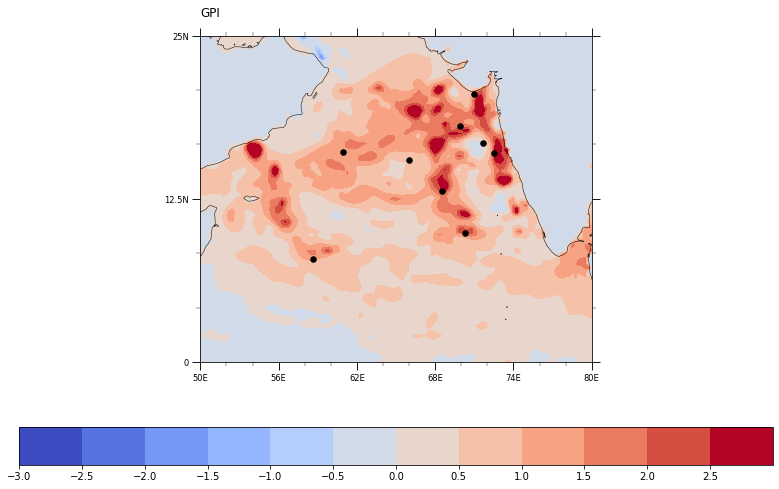

In [28]:
convec_phases = [2,3,4]
dates_convec = rmm_subset[rmm_subset.phase.isin(convec_phases)].date.values
GP_convec  = anom.sel(time=dates_convec).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_convec,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

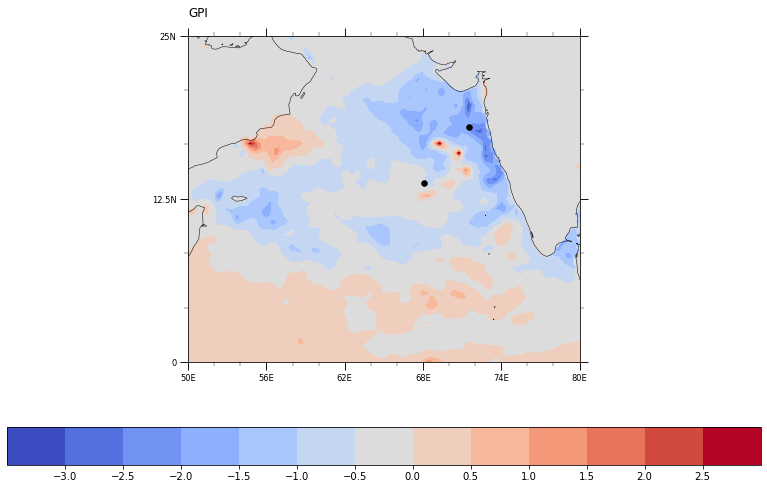

In [29]:
supres_phases = [6,7,8]
dates_supres = rmm_subset[rmm_subset.phase.isin(supres_phases)].date.values
GP_supres  = anom.sel(time=dates_supres).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_supres,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

In [30]:
#IGNORE THIS SECTION

#def add_axes(fig, grid_space, date):
#    ax = fig.add_subplot(grid_space,
#                        projection=ccrs.PlateCarree(central_longitude=-160))
#    ax.set_extent(40, 80, 0, 30], crs=ccrs.PlateCarree())

    # Usa geocat.viz.util convenience function to set axes parameters
#    gv.set_axes_limits_and_ticks(ax,
#                                 ylim=(0, 30),
#                                 xticks=np.arange(40, 80, 5),
#                                 yticks=np.arange(0, 30, 5))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
#    gv.add_lat_lon_ticklabels(ax)
    # Remove the degree symbol from tick labels
#    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
#    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    # Use geocat.viz.util convenience function to add minor and major tick lines
#    gv.add_major_minor_ticks(ax, labelsize=8)

    # Make sure that tick marks are only on the left and bottom sides of subplot
#    ax.tick_params('both', which='both', top=False, right=False)

    # Add land to the subplot
#    ax.add_feature(cfeature.LAND,
#                   facecolor='lightgray',
#                   edgecolor='black',
#                   linewidths=0.5,
#                   zorder=2)

    # Set subplot titles
#    gv.set_titles_and_labels(ax,
#                             lefttitle='',
#                             lefttitlefontsize=10,
#                             righttitle='',
#                             righttitlefontsize=10)
#    ax.set_title(convert_date(date), fontsize=10, y=1.04)

#    return ax


#minlon =  40.
#maxlon =  80.
#minlat =   0.
#maxlat =   30.

#def create_fig(grid, fig, title):
    # Add the axes
#    ax1 = plot_GPI(fig, grid[0, 0], dates[0])
#    ax2 = add_axes(fig, grid[0, 1], dates[1])
#    ax3 = add_axes(fig, grid[1, 0], dates[2])
#    ax4 = add_axes(fig, grid[1, 1], dates[3])

    # Create a dictionary with contour attributes
#    contourf_kw = dict(transform=ccrs.PlateCarree(),
#                       levels=21,
#                       cmap=cmaps.BlueRed,
#                       add_colorbar=False,
#                       add_labels=False,
#                      vmin=-5,
#                       vmax=5,
#                       extend='both',
#                       zorder=1)

    # Plot the filled contours
#    contour1 = data1.plot.contourf(ax=ax1, **contourf_kw)
#    contour2 = data2.plot.contourf(ax=ax2, **contourf_kw)
#    contour3 = data3.plot.contourf(ax=ax3, **contourf_kw)
#    contour4 = data4.plot.contourf(ax=ax4, **contourf_kw)

    # Add colorbar for all four plots
#    fig.colorbar(contour4,
#                 ax=[ax1, ax2, ax3, ax4],
#                 ticks=np.linspace(-5, 5, 11),
#                 drawedges=True,
#                 orientation='horizontal',
#                 shrink=0.5,
#                 pad=0.075,
#                 extendfrac='auto',
#                 extendrect=True)

    # Add figure title
#    fig.suptitle(title, fontsize=18, y=0.9)

#    plt.show()

-0.8613546109916137 0.0
-0.12174322405845964


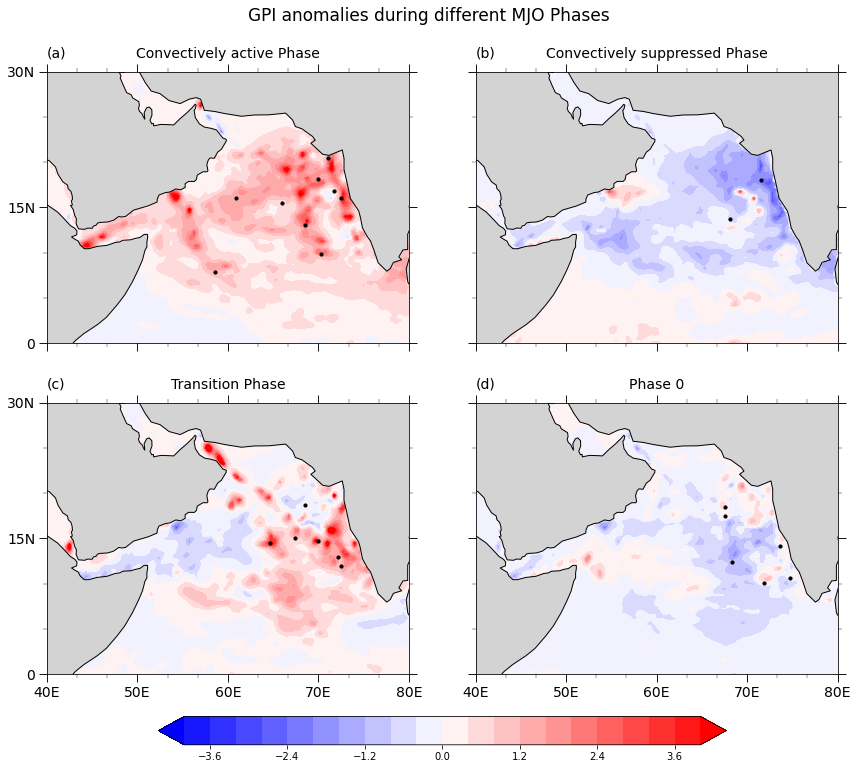

In [29]:
#Plotting a 2x2 panel plot for GP anomalies

minlon =  40.
maxlon =  80.
minlat =   0.
maxlat =   30.

#minC = -3
#maxC =  3
#intC =  .3

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2,
                       2,
                       layout="constrained",
                       gridspec_kw={'wspace': 0.06, 'hspace': 0.07},
                       subplot_kw={"projection": projection})

#constrained_layout=True,
# Set figure size (width, height) in inches
fig.set_size_inches((12,10))

# Add continents
continents = cartopy.feature.NaturalEarthFeature(name="coastline",
                                                 category="physical",
                                                 scale="110m",
                                                 edgecolor="black",
                                                 facecolor="lightgray")
[axes.add_feature(continents) for axes in ax.flat]


colormap='bwr'

# Specify which contour levels to draw
contour_lev = np.arange(-4,4.4,0.4)           #(-4.2,4.2, 0.4)

#ax[0]=plot_GPI(GP_supres,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
#ax[0].scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')


# landsea mask

era5_invar_dir = '/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/'
fname = era5_invar_dir + 'e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
dslsm  = xr.open_dataset(fname)   

latS=0
latN=30
lonW=40
lonE=80

lsm = dslsm.LSM[0,:,:].sel(latitude=slice(latN,latS), longitude=slice(lonW,lonE))

# Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(xlim=(minlon, maxlon),
              ylim=(minlat, maxlat),
              xticks=np.linspace(minlon, maxlon, 5),
              yticks=np.linspace(minlat, maxlat,3),
              transform=projection,  # ds projection
              add_colorbar=False,  # don't add individual colorbars for each plot call
              add_labels=False,  # turn off xarray's automatic Lat, lon labels
)


GP_convec  = anom.sel(time=dates_convec).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lat

#GP_convec = GP_convec.where(lsm==0)   # apply the land-sea mask

GPconvec_plot = GP_convec.plot.contourf(ax=ax[0,0],levels=contour_lev,cmap=colormap,extend='both',**kwargs)
ax[0,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,0].set_title('Convectively active Phase',fontsize=14,y=1.03)
ax[0,0].set_title('(a)',loc='left',fontsize=14,y=1.03)


GP_supres  = anom.sel(time=dates_supres).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lat

#GP_supres= GP_supres.where(lsm==0)   # apply the land-sea mask

GPsupres_plot = GP_supres.plot.contourf(ax=ax[0,1],levels=contour_lev,cmap=colormap,extend='both',**kwargs)
ax[0,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,1].set_title('Convectively suppressed Phase',fontsize=14,y=1.03)
ax[0,1].set_title('(b)',loc='left',fontsize=14,y=1.03)


GP_transition  = anom.sel(time=dates_transition).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lat

#GP_transition = GP_transition.where(lsm==0)   # apply the land-sea mask

GPtransition_plot = GP_transition.plot.contourf(ax=ax[1,0],levels=contour_lev,cmap=colormap,extend='both',**kwargs)
ax[1,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,0].set_title('Transition Phase',fontsize=14,y=1.03)
ax[1,0].set_title('(c)',loc='left',fontsize=14,y=1.03)


GP_zero  = anom.sel(time=dates_zero).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lat

#GP_zero = GP_zero.where(lsm==0)   # apply the land-sea mask

GP0_plot = GP_zero.plot.contourf(ax=ax[1,1],levels=contour_lev,cmap=colormap,extend='both',**kwargs)
ax[1,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,1].set_title('Phase 0',fontsize=14,y=1.03)
ax[1,1].set_title('(d)',loc='left',fontsize=14,y=1.03)



fig.suptitle('GPI anomalies during different MJO Phases',fontsize=17, y=1.05)

#fig.suptitle('KGPP anomalies during different MJO Phases',fontsize=16)
#for row in range(2):

#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig.colorbar(GPtransition_plot, ax=ax[1, :], shrink=0.7, location='bottom')    #extend='both' 

#fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.2,
#                            wspace=0.2)

#plt.subplots_adjust(hspace=-0.1,wspace=0.15)

#print(GP_zero)
print(GP_zero.sel(latitude=15,longitude=65).values, GP_zero.sel(latitude=20,longitude=75).values)
print(GP_supres.sel(latitude=24,longitude=63).values)

for ax in ax.flat:
    gv.add_major_minor_ticks(ax,labelsize=14)
    gv.add_lat_lon_ticklabels(ax)
    ax.label_outer()
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    
#fig.tight_layout()

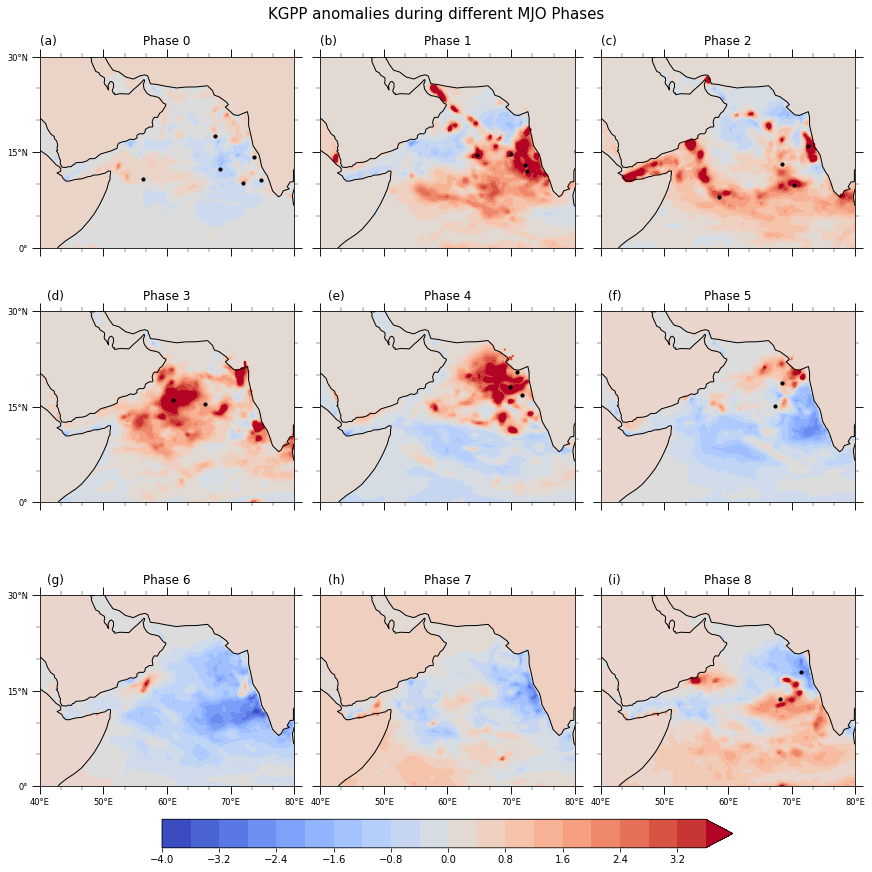

In [156]:
minlon =  40.
maxlon =  80.
minlat =   0.
maxlat =   30.

minC = -4
maxC =  4
intC =  .4

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(3,
                       3,
                       constrained_layout=True,
                       subplot_kw={"projection": projection})


# Set figure size (width, height) in inches
fig.set_size_inches((12,12))

# Add continents
continents = cartopy.feature.NaturalEarthFeature(name="coastline",
                                                 category="physical",
                                                 scale="110m",
                                                 edgecolor="black",
                                                 facecolor="lightgray")
[axes.add_feature(continents) for axes in ax.flat]


# landsea mask

era5_invar_dir = '/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/'
fname = era5_invar_dir + 'e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
dslsm  = xr.open_dataset(fname)   

latS=0
latN=30
lonW=40
lonE=80

lsm = dslsm.LSM[0,:,:].sel(latitude=slice(latN,latS), longitude=slice(lonW,lonE))



zero_phase = [0]
dates_zero = rmm_subset[rmm_subset.phase.isin(zero_phase)].date.values
GP_zero  = anom.sel(time=dates_zero).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(zero_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(zero_phase)].lat

#GP_zero = GP_zero.where(lsm==0)   # apply the land-sea mask

colormap='coolwarm'

# Specify which contour levels to draw
contour_lev = np.arange(-4,4, 0.4)

#ax[0]=plot_GPI(GP_supres,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
#ax[0].scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')


# Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(xlim=(minlon, maxlon),
              ylim=(minlat, maxlat),
              xticks=np.linspace(minlon, maxlon, 5),
              yticks=np.linspace(minlat, maxlat,3),
              transform=projection,  # ds projection
              add_colorbar=False,  # don't add individual colorbars for each plot call
              add_labels=False,  # turn off xarray's automatic Lat, lon labels
)



# Plot filled contour
GP0_plot = GP_zero.plot.contourf(ax=ax[0,0],levels=contour_lev,cmap=colormap,**kwargs)
#cbar = plt.colorbar(GP0_plot,ax=ax[0,0],
#                    orientation='horizontal',
#                    shrink=0.9,
#                    pad=0.001,
#                    extendrect=True,
#                    extendfrac='auto')
ax[0,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,0].set_title('Phase 0',fontsize=12,y=1.03)
ax[0,0].set_title('(a)',loc='left',fontsize=12,y=1.03)

# Make colorbar tick labels larger and rotate them
#cbar.ax.tick_params(labelsize=10, rotation=0)

# Use geocat.viz.util convenience function to add minor and major tick lines
#gv.add_major_minor_ticks(ax[0,0])
#gv.add_major_minor_ticks(ax[0,0])

# Use geocat.viz.util convenience function to make plots look like NCL plots by
# using latitude, longitude tick labels
#gv.add_lat_lon_ticklabels(ax[0,0])
#gv.add_lat_lon_ticklabels(ax[0,0])


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++

one_phase = [1]
dates_one = rmm_subset[rmm_subset.phase.isin(one_phase)].date.values
GP_one  = anom.sel(time=dates_one).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(one_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(one_phase)].lat

GP1_plot = GP_one.plot.contourf(ax=ax[0,1],levels=contour_lev,cmap=colormap,**kwargs)
#cbar = plt.colorbar(GP1_plot,ax=ax[0,1],
#                    orientation='horizontal',
#                    shrink=0.9,
#                    pad=0.001,
#                    extendrect=True,
#                    extendfrac='auto')
ax[0,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,1].set_title('Phase 1',fontsize=12,y=1.03)
ax[0,1].set_title('(b)',loc='left',fontsize=12,y=1.03)


two_phase = [2]
dates_two = rmm_subset[rmm_subset.phase.isin(two_phase)].date.values
GP_two  = anom.sel(time=dates_two).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(two_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(two_phase)].lat

GP2_plot = GP_two.plot.contourf(ax=ax[0,2],levels=contour_lev,cmap=colormap,**kwargs)
ax[0,2].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,2].set_title('Phase 2',fontsize=12,y=1.03)
ax[0,2].set_title('(c)',loc='left',fontsize=12,y=1.03)

three_phase = [3]
dates_three = rmm_subset[rmm_subset.phase.isin(three_phase)].date.values
GP_three  = anom.sel(time=dates_three).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(three_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(three_phase)].lat

GP3_plot = GP_three.plot.contourf(ax=ax[1,0],levels=contour_lev,cmap=colormap,**kwargs)
ax[1,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,0].set_title('Phase 3',fontsize=12,y=1.03)
ax[1,0].set_title('(d)',loc='left',fontsize=12,x=0.03,y=1.03)

four_phase = [4]
dates_four = rmm_subset[rmm_subset.phase.isin(four_phase)].date.values
GP_four  = anom.sel(time=dates_four).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(four_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(four_phase)].lat

GP4_plot = GP_four.plot.contourf(ax=ax[1,1],levels=contour_lev,cmap=colormap,**kwargs)
ax[1,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,1].set_title('Phase 4',fontsize=12,y=1.03)
ax[1,1].set_title('(e)',loc='left',fontsize=12,x=0.03,y=1.03)


five_phase = [5]
dates_five = rmm_subset[rmm_subset.phase.isin(five_phase)].date.values
GP_five  = anom.sel(time=dates_five).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(five_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(five_phase)].lat

GP5_plot = GP_five.plot.contourf(ax=ax[1,2],levels=contour_lev,cmap=colormap,**kwargs)
ax[1,2].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,2].set_title('Phase 5',fontsize=12,y=1.03)
ax[1,2].set_title('(f)',loc='left',fontsize=12,x=0.03,y=1.03)


six_phase = [6]
dates_six = rmm_subset[rmm_subset.phase.isin(six_phase)].date.values
GP_six  = anom.sel(time=dates_six).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(six_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(six_phase)].lat

GP6_plot = GP_six.plot.contourf(ax=ax[2,0],levels=contour_lev,cmap=colormap,**kwargs)
ax[2,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[2,0].set_title('Phase 6',fontsize=12,y=1.03)
ax[2,0].set_title('(g)',loc='left',fontsize=12,x=0.03,y=1.03)

seven_phase = [7]
dates_seven = rmm_subset[rmm_subset.phase.isin(seven_phase)].date.values
GP_seven  = anom.sel(time=dates_seven).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(seven_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(seven_phase)].lat

GP7_plot = GP_seven.plot.contourf(ax=ax[2,1],levels=contour_lev,cmap=colormap,**kwargs)
ax[2,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[2,1].set_title('Phase 7',fontsize=12,y=1.03)
ax[2,1].set_title('(h)',loc='left',fontsize=12,x=0.03,y=1.03)

eight_phase = [8]
dates_eight = rmm_subset[rmm_subset.phase.isin(eight_phase)].date.values
GP_eight  = anom.sel(time=dates_eight).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(eight_phase)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(eight_phase)].lat

GP8_plot = GP_eight.plot.contourf(ax=ax[2,2],levels=contour_lev,cmap=colormap,**kwargs)
ax[2,2].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[2,2].set_title('Phase 8',fontsize=12,y=1.03)
ax[2,2].set_title('(i)',loc='left',fontsize=12,x=0.03,y=1.03)

#rect=[0.85, 0.15, 0.05, 0.7]
#cbar_ax = fig.add_axes(rect)

fig.colorbar(GP2_plot,ax=ax[2, :3], shrink=0.7, location='bottom')
fig.suptitle('KGPP anomalies during different MJO Phases',fontsize=15)
#plt.subplots_adjust(hspace=0.3,wspace=0.08)

for ax in ax.flat:
    gv.add_major_minor_ticks(ax)
    gv.add_lat_lon_ticklabels(ax)
    ax.label_outer()
    
#fig.tight_layout()    